In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = dsets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True)


In [3]:
# 100 차원 랜덤 노이즈 -> 28 * 28 이미지
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()  # 출력 범위 [-1, 1]
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)


In [4]:
# 28 * 28 이미지 -> 1차원 벡터 (0 또는 1)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2), # 음수 값 허용을 위해 LeakyReLU 사용
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # 출력 범위 [0, 1]
        )

    def forward(self, img):
        return self.model(img.view(-1, 28 * 28))


In [5]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)  # Xavier 정규 분포 초기화
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)  # 바이어스는 0으로 초기화

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('high')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

discriminator.apply(weights_init)
generator.apply(weights_init)

generator = torch.compile(generator, mode='default')
discriminator = torch.compile(discriminator, mode='default')

criterion = nn.BCELoss() # 분류 대상은 진짜 또는 가짜 단 두가지 ->  BCE 사용
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [7]:
print(next(generator.parameters()).device)
print(next(discriminator.parameters()).device)


cuda:0
cuda:0


In [8]:
'''
학습 알고리즘
1. 노이즈 샘플링
2. 실제 데이터 샘플링
3. 판별자 학습
4. 생성자를 통해 데이터 샘플링
5. 판별자를 통해 가짜 데이터 판별
6. 생성자 학습
7. 위 과정 반복
'''

num_epochs = 200
max_norm = 1.0
d_losses = []
g_losses = []

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        # 진짜 이미지와 가짜 이미지 레이블 생성
        imgs = imgs.to(device)
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)
        
        # 판별자 학습
        optimizer_D.zero_grad()
        outputs = discriminator(imgs)
        d_loss_real = criterion(outputs, real_labels)
        
        # 생성자를 통해 가짜 이미지 생성
        z = torch.randn(imgs.size(0), 100).to(device)
        fake_imgs = generator(z)
        outputs = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        
        # 판별자 손실 계산 및 역전파
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        
        # 가중치 폭발 현상 해결을 위한 가중치 클리핑
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm)
        optimizer_D.step()

        # 생성자 학습
        optimizer_G.zero_grad()
        outputs = discriminator(fake_imgs)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        
        # 가중치 폭발 현상 해결을 위한 가중치 클리핑
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm)
        optimizer_G.step()
    
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')


Epoch [10/200], d_loss: 0.4351, g_loss: 3.9801
Epoch [20/200], d_loss: 1.0464, g_loss: 0.9551
Epoch [30/200], d_loss: 1.1030, g_loss: 1.5010
Epoch [40/200], d_loss: 1.3557, g_loss: 1.1451
Epoch [50/200], d_loss: 1.0456, g_loss: 1.5430
Epoch [60/200], d_loss: 1.2242, g_loss: 0.8798
Epoch [70/200], d_loss: 1.0540, g_loss: 0.8698
Epoch [80/200], d_loss: 1.2333, g_loss: 1.2647
Epoch [90/200], d_loss: 1.0962, g_loss: 1.4726
Epoch [100/200], d_loss: 1.1125, g_loss: 1.1193
Epoch [110/200], d_loss: 1.0854, g_loss: 1.5415
Epoch [120/200], d_loss: 1.1587, g_loss: 1.0770
Epoch [130/200], d_loss: 1.0710, g_loss: 1.1319
Epoch [140/200], d_loss: 1.0436, g_loss: 0.8248
Epoch [150/200], d_loss: 1.1185, g_loss: 1.4726
Epoch [160/200], d_loss: 0.9164, g_loss: 1.7804
Epoch [170/200], d_loss: 0.9698, g_loss: 1.1563
Epoch [180/200], d_loss: 1.0164, g_loss: 1.4823
Epoch [190/200], d_loss: 0.9723, g_loss: 1.5105
Epoch [200/200], d_loss: 0.9889, g_loss: 1.2794


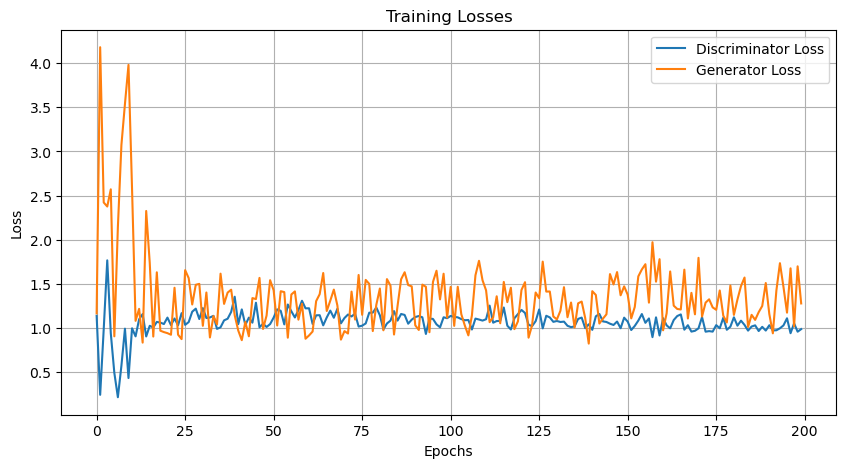

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

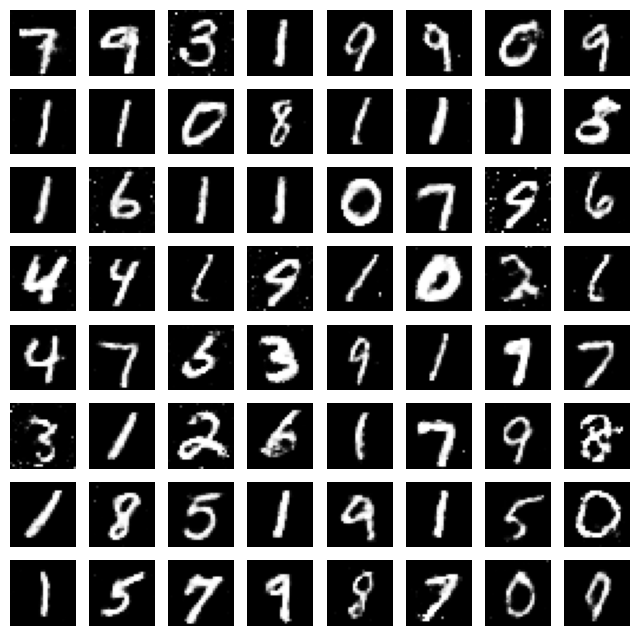

In [11]:
# 랜덤 노이즈로 생성된 이미지 시각화
with torch.no_grad():
    z = torch.randn(64, 100).to(device)
    fake_images = generator(z)

plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(fake_images[i].view(28, 28).cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()
